In [1]:
from collections import defaultdict
import csv
import numpy as np
from numpy import genfromtxt
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate
pd.set_option("display.precision", 1)

In [2]:
def load_data():
    ''' called to load preprepared data for the lab '''
    item_train = genfromtxt('item_train.csv', delimiter=",")
    user_train = genfromtxt('user_train.csv', delimiter=",")
    y_train    = genfromtxt('y_train.csv', delimiter=",")
    with open('content_item_train_header.txt', newline='') as f:
        item_features = list(csv.reader(f))[0]
    with open('content_user_train_header.txt', newline='') as f:
        user_features = list(csv.reader(f))[0]
    item_vecs = genfromtxt('item_vecs.csv', delimiter=",")

    wisata_dict = defaultdict(dict)
    count = 0

    with open('destinasi_list.csv', newline='') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        for line in reader:
            if count == 0:
                count += 1  #skip header
                #print(line) print
            else:
                count += 1
                destinasi_id = int(line[0])
                wisata_dict[destinasi_id]["title"] = line[1]
                wisata_dict[destinasi_id]["genre"] = line[2]



    return(item_train, user_train, y_train, item_features, user_features, item_vecs, wisata_dict)

def pprint_train(x_train, features, vs, u_s, maxcount=5, user=True):
    """ Prints user_train or item_train nicely """
    if user:
        flist = [".0f", ".0f", ".1f",
                 ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f", ".1f"]
    else:
        flist = [".0f", ".0f", ".1f",
                 ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f", ".0f"]

    head = features[:vs]
    if vs < u_s: print("error, vector start {vs} should be greater then user start {u_s}")
    for i in range(u_s):
        head[i] = "[" + head[i] + "]"
    genres = features[vs:]
    hdr = head + genres
    disp = [split_str(hdr, 5)]
    count = 0
    for i in range(0, x_train.shape[0]):
        if count == maxcount: break
        count += 1
        disp.append([x_train[i, 0].astype(int),
                     x_train[i, 1].astype(int),
                     x_train[i, 2].astype(float),
                     *x_train[i, 3:].astype(float)
                    ])
    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=flist, numalign='center')
    return table


def split_str(ifeatures, smax):
    ''' split the feature name strings to tables fit '''
    ofeatures = []
    for s in ifeatures:
        if not ' ' in s:  # skip string that already have a space
            if len(s) > smax:
                mid = int(len(s)/2)
                s = s[:mid] + " " + s[mid:]
        ofeatures.append(s)
    return ofeatures


def print_pred_wisata(y_p, item, wisata_dict, maxcount=10):
    """ print results of prediction of a new user. inputs are expected to be in
        sorted order, unscaled. """
    count = 0
    disp = [["Nama Tempat", "Kategori"]]

    for i in range(0, y_p.shape[0]):
        if count == maxcount:
            break
        count += 1
        destinasi_id = item[i, 0].astype(int)
        disp.append([wisata_dict[destinasi_id]['title'], wisata_dict[destinasi_id]['genre']])

    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow")
    return table

    return result

def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict maxtrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (num_items, 1))
    return user_vecs

# predict on  everything, filter on print/use
def predict_uservec(user_vecs, item_vecs, model, u_s, i_s, scaler):
    """ given a scaled user vector, does the prediction on all movies in scaled print_item_vecs returns
        an array predictions sorted by predicted rating,
        arrays of user and item, sorted by predicted rating sorting index
    """
    y_p = model.predict([user_vecs[:, u_s:], item_vecs[:, i_s:]])
    y_pu = scaler.inverse_transform(y_p)

    if np.any(y_pu < 0):
        print("Error, expected all positive predictions")
    sorted_index = np.argsort(-y_pu, axis=0).reshape(-1).tolist()  #negate to get largest rating first
    sorted_ypu   = y_pu[sorted_index]
    sorted_items = item_vecs[sorted_index]
    sorted_user  = user_vecs[sorted_index]
    return(sorted_index, sorted_ypu, sorted_items, sorted_user)


# def get_item_genres(item_gvec, genre_features):
#     ''' takes in the item's genre vector and list of genre names
#     returns the feature names where gvec was 1 '''
#     offsets = np.nonzero(item_gvec)[0]
#     genres = [genre_features[i] for i in offsets]
#     return genres


def print_existing_user(y_p, y, user, items, ivs, uvs, wisata_dict, maxcount=10):
    """ print results of prediction for a user who was in the database.
        Inputs are expected to be in sorted order, unscaled.
    """
    count = 0
    disp = [["y_p", "y", "user", "user kategori ave", "destinasi rating ave", "destinasi id", "Nama tempat",]]
    count = 0
    for i in range(0, y.shape[0]):
        if y[i, 0] != 0:  # zero means not rated
            if count == maxcount:
                break
            count += 1
            destinasi_id = items[i, 0].astype(int)

            offsets = np.nonzero(items[i, ivs:] == 1)[0]
            genre_ratings = user[i, uvs + offsets]
            disp.append([y_p[i, 0], y[i, 0],
                         user[i, 0].astype(int),      # userid
                         np.array2string(genre_ratings,
                                         formatter={'float_kind':lambda x: "%.1f" % x},
                                         separator=',', suppress_small=True),
                         items[i, 2].astype(float),
                         destinasi_id,
                         wisata_dict[destinasi_id]['title'],
                         wisata_dict[destinasi_id]['genre']])

    table = tabulate.tabulate(disp, tablefmt='html', headers="firstrow", floatfmt=[".1f", ".1f", ".0f", ".2f", ".1f"])
    return table

In [3]:
top10destinasi_df = pd.read_csv("topten.csv")
bykategori_df = pd.read_csv("bykategori.csv")
top10destinasi_df

,Id_destinasi,num ratings,ave rating,Nama,Kategori
0,145,198,4.1,Pulau Peucang,"Alam,Air,Petualangan"
1,147,188,4.0,Saba Baduy,"Alam,Petualangan,Sejarah&Budaya"
2,178,185,4.1,Saung budaya raden saleh,Pendidikan
3,8,170,3.9,Taman Pesisir Pantai Penyu Pangumbahan,"Keluarga,Pendidikan"
4,45,149,4.2,Sukasantai Farmstay,"Keluarga,Alam"
5,69,149,3.8,Masjid Agung Tasikmalaya,"Keluarga,Religi"
6,86,143,4.1,Masjid Agung Ciamis,"Keluarga,Pendidikan,Religi"
7,294,141,4.0,Sato Land Interactive Zoo,"Keluarga,Pendidikan"
8,349,132,3.9,Arung Jeram Cimanuk,"Alam,Air,Petualangan"
9,354,131,4.2,Hutan Mati Gunung Papandayan,"Alam,Petualangan"


In [4]:
bykategori_df

,Kategori,num_kategori,ave rating per kategori,ratings per kategori
0,Keluarga,215,3.2,349
1,Alam,210,3.6,414
2,Air,169,3.0,352
3,Pendidikan,74,2.5,286
4,Petualangan,84,2.9,342
5,Sejarah&Budaya,49,2.5,289
6,Religi,17,2.6,306
7,Kuliner,51,3.7,429


In [5]:
# Load Data, set configuration variables
item_train, user_train, y_train, item_features, user_features, item_vecs, wisata_dict = load_data()

num_user_features = user_train.shape[1] - 3  # remove userid, rating count and ave rating during training
num_item_features = item_train.shape[1] - 1  # remove movie id at train time
uvs = 3  # user genre vector start
ivs = 3  # item genre vector start
u_s = 3  # start of columns to use in training, user
i_s = 1  # start of columns to use in training, items
print(f"Number of training vectors: {len(item_train)}")

Number of training vectors: 1279


In [6]:
pprint_train(user_train, user_features, uvs,  u_s, maxcount=5)
look = pd.read_html(pprint_train(user_train, user_features, uvs, u_s, maxcount=5))
look[0]

,[Id_ user],[rating _count],[ave_ count],Sejarah &Budaya,Alam,Air,Kul iner,Rel igi,Pendi dikan,Kelu arga,Petua langan
0,230001,10,2.9,3.0,4.0,3.0,4.0,1.0,1.0,3.0,4.0
1,230001,10,2.9,3.0,4.0,3.0,4.0,1.0,1.0,3.0,4.0
2,230001,10,2.9,3.0,4.0,3.0,4.0,1.0,1.0,3.0,4.0
3,230001,10,2.9,3.0,4.0,3.0,4.0,1.0,1.0,3.0,4.0
4,230001,10,2.9,3.0,4.0,3.0,4.0,1.0,1.0,3.0,4.0


In [7]:
pprint_train(item_train, item_features, ivs, i_s, maxcount=5, user=False)
look = pd.read_html(pprint_train(item_train, item_features, ivs, i_s, maxcount=5))
look[0]

,[Id_des tinasi],Tahun,Rat ing,Sejarah &Budaya,Alam,Air,Kul iner,Rel igi,Pendi dikan,Kelu arga,Petua langan
0,1,2023,4.6,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2023,4.6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,3,2023,4.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,2023,4.6,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,5,2023,4.6,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
print(f"y_train[:5]: {y_train[:5]}")

y_train[:5]: [3.6 3.6 3.6 3.6 3.6]


In [9]:
# scale training data
item_train_unscaled = item_train
user_train_unscaled = user_train
y_train_unscaled    = y_train

scalerItem = StandardScaler()
scalerItem.fit(item_train)
item_train = scalerItem.transform(item_train)

scalerUser = StandardScaler()
scalerUser.fit(user_train)
user_train = scalerUser.transform(user_train)

scalerTarget = MinMaxScaler((-1, 1))
scalerTarget.fit(y_train.reshape(-1, 1))
y_train = scalerTarget.transform(y_train.reshape(-1, 1))
#ynorm_test = scalerTarget.transform(y_test.reshape(-1, 1))

print(np.allclose(item_train_unscaled, scalerItem.inverse_transform(item_train)))
print(np.allclose(user_train_unscaled, scalerUser.inverse_transform(user_train)))

True
True


In [10]:
item_train, item_test = train_test_split(item_train, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_train, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_train,    train_size=0.80, shuffle=True, random_state=1)
print(f"movie/item training data shape: {item_train.shape}")
print(f"movie/item test data shape: {item_test.shape}")

movie/item training data shape: (1023, 11)
movie/item test data shape: (256, 11)


In [11]:
pprint_train(user_train, user_features, uvs, u_s, maxcount=5)
look = pd.read_html(pprint_train(user_train, user_features, uvs, u_s, maxcount=5))
look[0]

,[Id_ user],[rating _count],[ave_ count],Sejarah &Budaya,Alam,Air,Kul iner,Rel igi,Pendi dikan,Kelu arga,Petua langan
0,1,0,0.5,-0.6,0.4,-0.0,1.2,-0.6,-0.5,1.0,1.0
1,1,1,1.4,0.6,0.4,1.9,0.3,2.3,0.6,-0.0,0.1
2,1,1,0.5,-0.6,0.4,-0.0,0.3,-0.6,0.6,1.9,0.1
3,-1,0,0.2,0.6,0.4,1.0,-1.7,0.4,-0.5,1.0,0.1
4,-1,0,0.0,0.6,-0.6,-0.0,-0.7,0.4,0.6,-0.0,0.1


In [12]:
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear'),
])

item_NN = tf.keras.models.Sequential([

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='linear'),
])

input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

input_item = tf.keras.layers.Input(shape=(num_item_features))
vm = item_NN(input_item)
vm = tf.linalg.l2_normalize(vm, axis=1)

output = tf.keras.layers.Dot(axes=1)([vu, vm])

model = tf.keras.Model([input_user, input_item], output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 8)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 sequential (Sequential)     (None, 32)                   39328     ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 32)                   39840     ['input_2[0][0]']             
                                                                                              

In [13]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=cost_fn)

In [14]:
tf.random.set_seed(1)

Epoch 1/100
32/32 [==============================] - 2s 7ms/step - loss: 0.1024
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0358
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0132
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0123
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0075
Epoch 8/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0072
Epoch 9/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0081
Epoch 10/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0058
Epoch 11/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0050
Epoch 12/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0042
Epoch 13/100
32/32 [=================

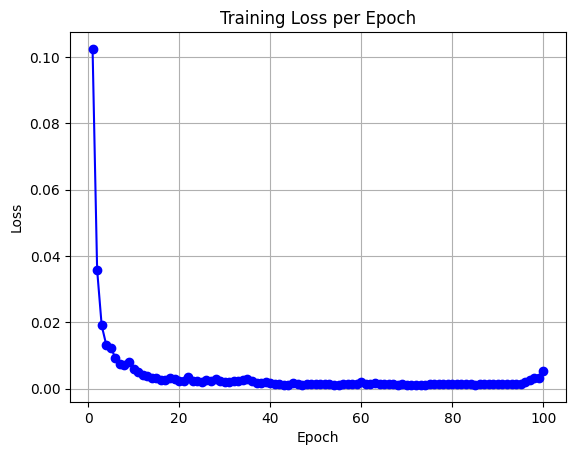

In [15]:
import matplotlib.pyplot as plt

# Ambil histori pelatihan dari objek History
history = model.fit([user_train[:, u_s:], item_train[:, i_s:]], y_train, epochs=100)

# Ambil nilai loss dari setiap epoch
loss_values = history.history['loss']

# Buat grafik loss terhadap epoch
plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [16]:
model.evaluate([user_test[:, u_s:], item_test[:, i_s:]], y_test)

8/8 [==============================] - 0s 3ms/step - loss: 0.0049


0.0049158260226249695

In [17]:
model.save("model_pariwisata.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
user_id = 230117
rating_count = 5
sejarahbudaya = 3
alam = 4
air = 4
kuliner = 4
religi = 2
pendidikan = 2
keluarga = 3
petualangan = 3
rating_avrg = (sejarahbudaya+alam+air+kuliner+religi+pendidikan+keluarga+petualangan)/8

user_vec = np.array([[user_id, rating_count, rating_avrg, sejarahbudaya, alam, air, kuliner, religi, pendidikan, keluarga, petualangan]])

In [21]:
# generate and replicate the user vector to match the number movies in the data set.
user_vecs = gen_user_vecs(user_vec,len(item_vecs))

# scale our user and item vectors
suser_vecs = scalerUser.transform(user_vecs)
sitem_vecs = scalerItem.transform(item_vecs)

# make a prediction
y_p = model.predict([suser_vecs[:, u_s:], sitem_vecs[:, i_s:]])

# unscale y prediction
y_pu = scalerTarget.inverse_transform(y_p)

# sort the results, highest prediction first
sorted_index = np.argsort(-y_pu,axis=0).reshape(-1).tolist()  #negate to get largest rating first
sorted_ypu   = y_pu[sorted_index]
sorted_items = item_vecs[sorted_index]  #using unscaled vectors for display

print_pred_wisata(sorted_ypu, sorted_items, wisata_dict, maxcount = 10)
look = pd.read_html(print_pred_wisata(sorted_ypu, sorted_items, wisata_dict, maxcount = 10))
look[0]

12/12 [==============================] - 0s 3ms/step


,Nama Tempat,Kategori
0,Hutan Kota Patriot Bina Bangsa,Keluarga|Alam
1,Pulau Empat,Alam|Air|Petualangan
2,Museum Trupark,Keluarga|Sejarah&Budaya|Pendidikan
3,Griya Hidroponik,Alam|Pendidikan
4,Museum Pusaka Keraton Kasepuhan,Sejarah&Budaya|Pendidikan
5,Kampung Daun Culture Gallery & Cafe,Keluarga|Alam|Kuliner
6,Pulau Lima,Alam|Air|Petualangan
7,museum pos indonesia,Keluarga|Sejarah&Budaya|Pendidikan
8,Taman Wisata Pulau Situ Gintung,Keluarga|Alam
9,museum geologi,Keluarga|Sejarah&Budaya|Pendidikan


In [22]:
data = print_pred_wisata(sorted_ypu, sorted_items, wisata_dict, maxcount = 10)
print(data)

<table>
<thead>
<tr><th>Nama Tempat                        </th><th>Kategori                          </th></tr>
</thead>
<tbody>
<tr><td>Hutan Kota Patriot Bina Bangsa     </td><td>Keluarga|Alam                     </td></tr>
<tr><td>Pulau Empat                        </td><td>Alam|Air|Petualangan              </td></tr>
<tr><td>Museum Trupark                     </td><td>Keluarga|Sejarah&amp;Budaya|Pendidikan</td></tr>
<tr><td>Griya Hidroponik                   </td><td>Alam|Pendidikan                   </td></tr>
<tr><td>Museum Pusaka Keraton Kasepuhan    </td><td>Sejarah&amp;Budaya|Pendidikan         </td></tr>
<tr><td>Kampung Daun Culture Gallery &amp; Cafe</td><td>Keluarga|Alam|Kuliner             </td></tr>
<tr><td>Pulau Lima                         </td><td>Alam|Air|Petualangan              </td></tr>
<tr><td>museum pos indonesia               </td><td>Keluarga|Sejarah&amp;Budaya|Pendidikan</td></tr>
<tr><td>Taman Wisata Pulau Situ Gintung    </td><td>Keluarga|Alam             

In [23]:
table_MN = pd.read_html(print_pred_wisata(sorted_ypu, sorted_items, wisata_dict, maxcount = 10))
df = table_MN[0]
df

,Nama Tempat,Kategori
0,Hutan Kota Patriot Bina Bangsa,Keluarga|Alam
1,Pulau Empat,Alam|Air|Petualangan
2,Museum Trupark,Keluarga|Sejarah&Budaya|Pendidikan
3,Griya Hidroponik,Alam|Pendidikan
4,Museum Pusaka Keraton Kasepuhan,Sejarah&Budaya|Pendidikan
5,Kampung Daun Culture Gallery & Cafe,Keluarga|Alam|Kuliner
6,Pulau Lima,Alam|Air|Petualangan
7,museum pos indonesia,Keluarga|Sejarah&Budaya|Pendidikan
8,Taman Wisata Pulau Situ Gintung,Keluarga|Alam
9,museum geologi,Keluarga|Sejarah&Budaya|Pendidikan
